## Using LSTMs to Predict Mid-Price Movement from the Limit Order Book

- The goal of this notebook is to predict whether the mid-price will decrease or increase during the next tick. This is accomplished through the usage of an LSTM in tensorflow.

### Import the necessary packages

In [1]:
#Package imports
import pandas as pd
import numpy as np
import os
import math
import sys
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
sys.path.insert(0, os.path.join(os.getcwd(), 'code'))

import Features as ftrs
import Preprocess as prpcs
import RNNModel as RNNM
from ml_analysis import MLOperator, MLEvaluator
path = os.path.join(os.getcwd(), 'data')

### Create features

In [2]:
#create features
features = ftrs.Features(message_filename='INTC_message.csv', orderbook_filename='INTC_OrderBook.csv')
features.CreateFeatures()
df = features.GetFeatures()
df.reset_index(inplace=True)

In [3]:
df.head(10)

,time,ask_price_1,ask_vol_1,bid_price_1,bid_vol_1,ask_price_2,ask_vol_2,bid_price_2,bid_vol_2,ask_price_3,...,rank_bid_vol_4,rank_ask_vol_4,rank_bid_vol_5,rank_ask_vol_5,corr_vol_1,corr_vol_2,corr_vol_3,corr_vol_4,corr_vol_5,label
0,34200.049011,275200,166,275100,300,275300,1000,275000,100,275400,...,1.0,1.0,0.714286,1.0,-0.353553,-1.000000,-1.000000,-1.0,1.0,0
1,34200.049078,275200,166,275100,300,275300,1000,275000,100,275400,...,1.0,1.0,0.750000,1.0,-0.377964,-1.000000,-1.000000,-1.0,1.0,0
2,34200.049110,275200,166,275100,300,275300,1000,275000,100,275400,...,1.0,1.0,1.000000,1.0,-0.395285,-1.000000,-1.000000,-1.0,1.0,0
3,34200.049301,275200,166,275100,300,275300,1000,275000,300,275400,...,1.0,1.0,1.000000,1.0,-0.408248,-1.000000,-1.000000,-1.0,1.0,0
4,34200.211338,275200,100,275100,300,275300,1000,275000,300,275400,...,1.0,1.0,1.000000,1.0,-0.228210,1.000000,-1.000000,1.0,1.0,1
5,34200.211338,275300,1000,275100,300,275400,373,275000,300,275500,...,1.0,1.0,1.000000,1.0,-0.240908,-0.473050,-0.225520,1.0,1.0,0
6,34200.211338,275300,1000,275100,300,275400,373,275000,300,275500,...,1.0,1.0,1.000000,1.0,-0.304357,-0.589368,-0.300033,1.0,1.0,0
7,34200.211455,275300,1000,275100,500,275400,373,275000,300,275500,...,1.0,1.0,1.000000,1.0,0.185984,-0.652473,-0.347997,1.0,1.0,0
8,34200.211462,275300,1000,275100,600,275400,373,275000,300,275500,...,1.0,1.0,1.000000,1.0,0.436498,-0.692712,-0.382586,1.0,1.0,0
9,34200.211464,275300,1000,275100,800,275400,373,275000,300,275500,...,1.0,1.0,1.000000,1.0,0.550304,-0.720750,-0.409048,1.0,1.0,0


### Preprocess data

In [4]:
preprocessor = prpcs.Preprocess(df)
filter1 = (df['actual_spread']-df['actual_spread'].shift(1)) >= 0
filter2 = df['label'].isin([-1,1])
use_features = list(df.columns)
use_features.remove('time')
use_features.remove('label')
preprocessor.filt(filter1 & filter2)
preprocessor.split_train_test(use_features, train_weight=0.8, n_steps=5)
preprocessor.normalize()
preprocessor.split_valid_test(nrow=150)

In [5]:
x_train,y_train,x_test,y_test, x_valid, y_valid = preprocessor.get_train_valid_split()
print (x_train.shape,y_train.shape,x_test.shape,y_test.shape, x_valid.shape, y_valid.shape)

(2557, 5, 64) (2557, 2) (487, 5, 64) (487, 2) (150, 5, 64) (150, 2)


In [6]:
# track the timestamp for MM strategy use
preprocessor.time_to_csv(path)

In [7]:
preprocessor.get_features().label.value_counts()

-1    1682
 1    1520
Name: label, dtype: int64

### Train the model

In [ ]:
Model = RNNM.RNNModel(learning_rate = 0.0001, keep_prob = 0.5, lambd = 0, n_epoch = 5000, n_batch = 700, display_step = 100,\
                 timesteps = 5, num_hidden = 10, num_classes = 2, num_layers = 2)
Model.Train(x_train, y_train, x_valid, y_valid, x_test, y_test)

Epoch: 0001 train_loss : 0.7226 train_acc : 0.5237 val_loss : 0.7525 val_acc : 0.5000
Epoch: 0101 train_loss : 0.6708 train_acc : 0.5811 val_loss : 0.7034 val_acc : 0.5667
Epoch: 0201 train_loss : 0.6404 train_acc : 0.6379 val_loss : 0.6422 val_acc : 0.6200
Epoch: 0301 train_loss : 0.5869 train_acc : 0.7071 val_loss : 0.5598 val_acc : 0.7533
Epoch: 0401 train_loss : 0.5324 train_acc : 0.7587 val_loss : 0.5034 val_acc : 0.7467
Epoch: 0501 train_loss : 0.4741 train_acc : 0.7896 val_loss : 0.4155 val_acc : 0.8333
Epoch: 0601 train_loss : 0.4588 train_acc : 0.8162 val_loss : 0.4083 val_acc : 0.8267
Epoch: 0701 train_loss : 0.4547 train_acc : 0.8244 val_loss : 0.4271 val_acc : 0.8400
Epoch: 0801 train_loss : 0.4394 train_acc : 0.8303 val_loss : 0.3627 val_acc : 0.8533
Epoch: 0901 train_loss : 0.4233 train_acc : 0.8365 val_loss : 0.3975 val_acc : 0.8600
Epoch: 1001 train_loss : 0.4032 train_acc : 0.8365 val_loss : 0.3369 val_acc : 0.8667
Epoch: 1101 train_loss : 0.4184 train_acc : 0.8455 val

### Evaluate the model

In [9]:
pred_df_train, pred_df_test = Model.Evaluate()

[0.89438202 0.88461538]
[0.83298097 0.84231537]


### Results on training data

Confusion matrix, without normalization
[[1194  157]
 [ 125 1081]]
Normalized confusion matrix
[[0.88378979 0.11621021]
 [0.10364842 0.89635158]]


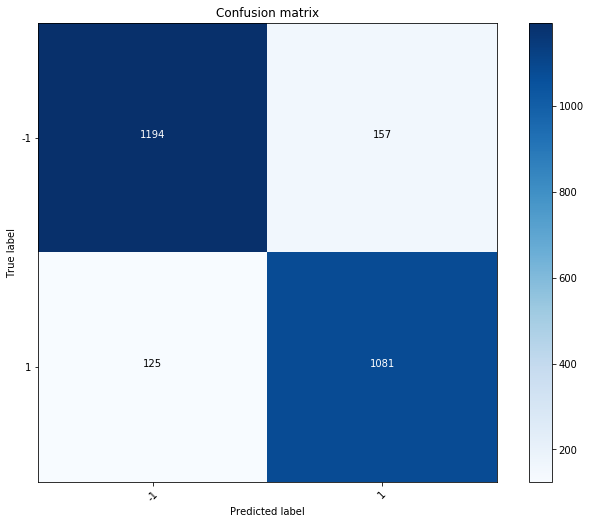

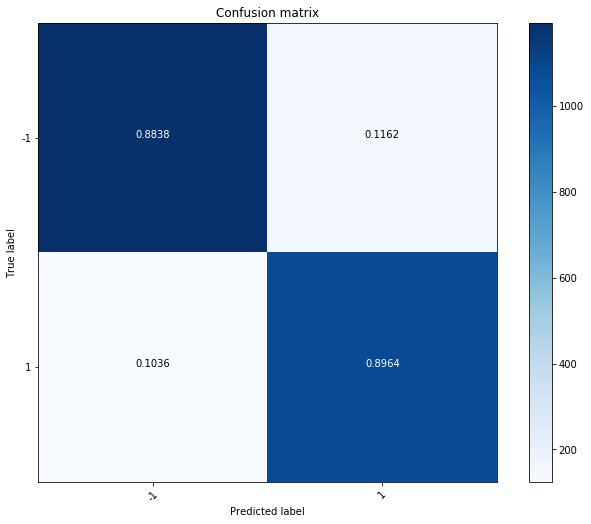

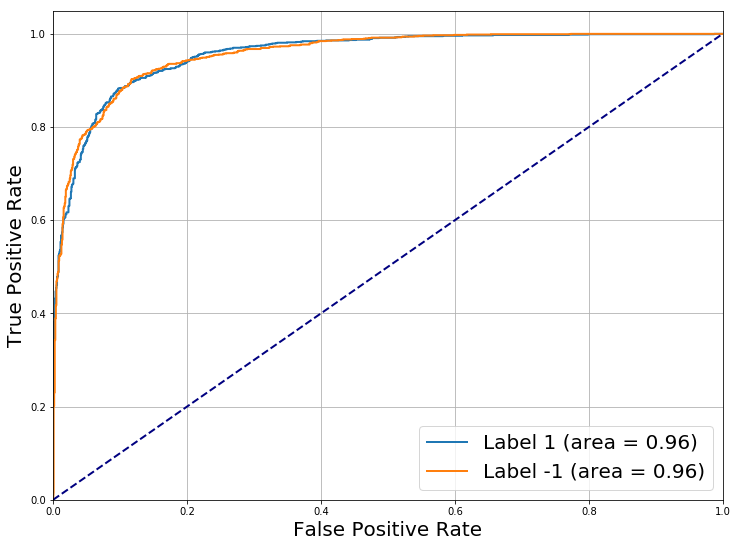

In [10]:
evaluator = MLEvaluator()
evaluator.set_pred_df(pred_df_train)
cf_mx_train = evaluator.generate_confusion_matrix()

fig = evaluator.plot_confusion_matrix(cf_mx_train.values, [-1, 1])
fig = evaluator.plot_confusion_matrix(cf_mx_train.values, [-1, 1], normalize=True)
fig = evaluator.plot_roc()

### Results on testing data

Confusion matrix, without normalization
[[197  57]
 [ 22 211]]
Normalized confusion matrix
[[0.77559055 0.22440945]
 [0.0944206  0.9055794 ]]


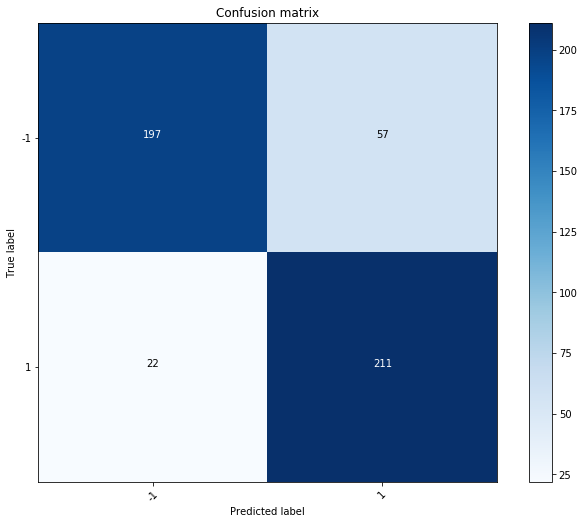

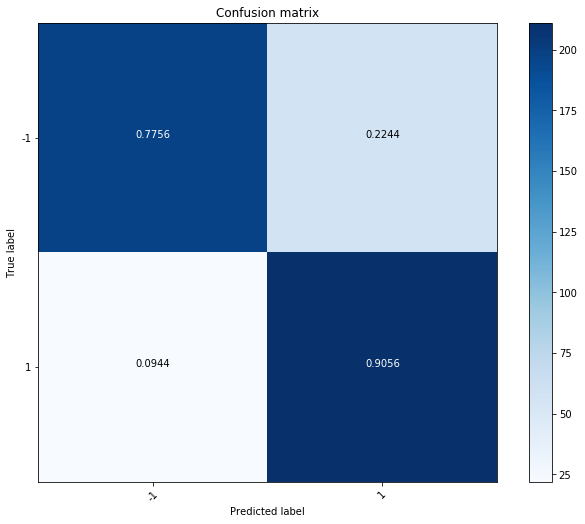

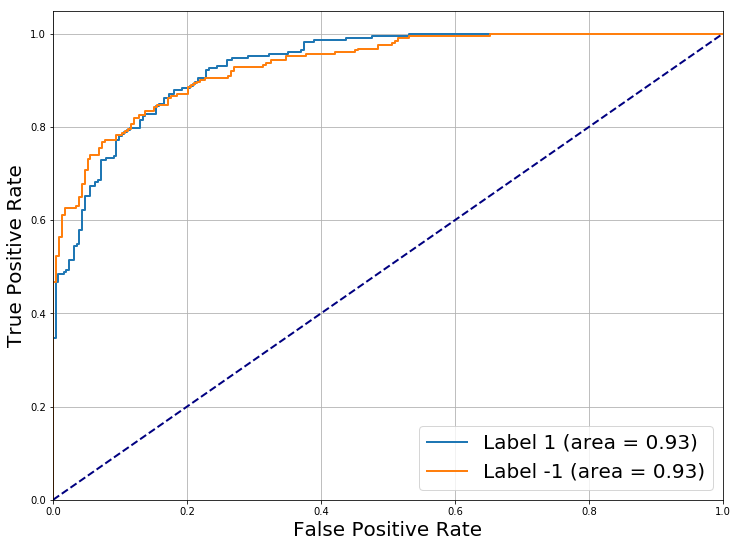

In [11]:
evaluator.set_pred_df(pred_df_test)
cf_mx_test = evaluator.generate_confusion_matrix()

fig = evaluator.plot_confusion_matrix(cf_mx_test.values, [-1, 1])
fig = evaluator.plot_confusion_matrix(cf_mx_test.values, [-1, 1], normalize=True)
fig = evaluator.plot_roc()